# Running Spectral Fitting

Fitting spectral methods on simulated power spectra.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats.mstats import normaltest

from fooof.sim import gen_power_spectrum, gen_group_power_spectra

In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.fit import *
from apm.fake import SimFits, print_res
from apm.plts import plot_psds, plot_psds_two
from apm.plts.fake import violin_errors, boxplot_errors
from apm.plts.utils import color_red_or_green

from apm.core.db import APMDB
from apm.core.io import save_pickle, load_pickle

from apm.sim.peaks import *

### Editorial Note

ToDo: remove old code.

In [3]:
# # # OLD:
# from apm.sim.peaks import _check_duplicate
# CEN_FREQS = np.load('/Users/tom/Code/Projects/APMethods/AperiodicMethods/apm/sim/data/freqs.npy')
# PROBS = np.load('/Users/tom/Code/Projects/APMethods/AperiodicMethods/apm/sim/data/probs.npy')

# def gen_osc_def(n_oscs=None):
#     """Generate a plausible oscillation distribution for a synthetic PSD.
#     Parameters
#     ----------
#     n_oscs : int, optional
#         Number of oscillations to generate. If None, picked at random. Default: None.
#     Returns
#     -------
#     oscs : list of list of [float, float, float], or []
#         Oscillation definitions.
#     """

#     #
#     if n_oscs is None:
#         n_oscs = np.random.choice([0, 1, 2], p=[1/3, 1/3, 1/3])

#     # Initialize list of oscillation definitions
#     oscs = []

#     # Define the power and bandwidth possibilities and probabilities
#     #pow_opts = [0.05, 0.10, 0.15, 0.20]
#     pow_opts = [0.15, 0.25, 0.5, 1.0]
#     pow_probs = [0.25, 0.25, 0.25, 0.25]
#     bw_opts = [1, 1.5, 2]
#     bw_probs = [1/3, 1/3, 1/3]

#     # Generate oscillation definitions
#     for osc in range(n_oscs):

#         cur_cen = np.random.choice(CEN_FREQS, p=PROBS)

#         while _check_duplicate(cur_cen, [it[0] for it in oscs]):
#             cur_cen = np.random.choice(CEN_FREQS, p=PROBS)

#         cur_amp = np.random.choice(pow_opts, p=pow_probs)
#         cur_bw = np.random.choice(bw_opts, p=bw_probs)

#         oscs.append([cur_cen, cur_amp, cur_bw])

#     return oscs

### Setup & Settings

In [4]:
# Notebook Settings
SAVE_FIG = False
SAVE_DATA = True

In [5]:
# Set up project database object
db = APMDB()

In [6]:
# General simulation settings
f_range = [3, 40]

off_val = 0

noise = 0.0

## Check out PSD generation and test fitting

In [7]:
# Generate a single simulated test power spectrum
exp_val = 1
peak_gen = gen_peak_def()
peaks = next(peak_gen)

In [8]:
# # Old version
# freqs, psd = sim_psd(f_range, exp_val, peaks, noise)
# # Plot and check a simulated spectrum, plotted in semi-log and log space
# plot_psds_two(freqs, psd, np.log10(freqs), np.log10(psd))

In [9]:
# Simulate an example power spectrum
freqs, psd = gen_power_spectrum(f_range, [off_val, exp_val], peaks, noise)

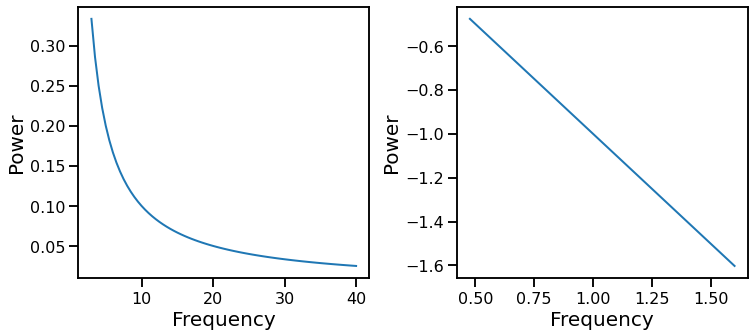

In [10]:
# Plot and check a simulated spectrum, plotted in semi-log and log space
plot_psds_two(freqs, psd, np.log10(freqs), np.log10(psd))

In [11]:
# Test out fits
print('True exponent value is ', str(exp_val), '\n')
print('OLS fit: \t', fit_ols(freqs, psd))
print('RLM fit: \t', fit_rlm(freqs, psd))
print('RLM-EA fit: \t', fit_rlm_alph(freqs, psd))
print('RLM-EO fit: \t', fit_rlm_oscs(freqs, psd))
print('RAN fit: \t', fit_ransac(freqs, psd))
print('RAN-EA fit: \t', fit_ransac_alph(freqs, psd))
print('RAN-EO fit: \t', fit_ransac_oscs(freqs, psd))
print('EXP fit: \t', fit_exp(freqs, psd))
print('EXP-EA fit: \t', fit_exp_alph(freqs, psd))
print('EXP-EO fit: \t', fit_exp_oscs(freqs, psd))
print('FOOOF fit: \t', fit_fooof(freqs, psd))

True exponent value is  1 

OLS fit: 	 -0.9999999999999998
RLM fit: 	 -0.9999999999999998
RLM-EA fit: 	 -1.0000000000000002
RLM-EO fit: 	 -0.9999999999999998
RAN fit: 	 -0.9999999999999999
RAN-EA fit: 	 -1.0
RAN-EO fit: 	 -0.9999999999999999
EXP fit: 	 -0.9999999999983533
EXP-EA fit: 	 -0.9999999999984178
EXP-EO fit: 	 -0.9999999999983533
FOOOF fit: 	 -1.0000000016880128


/Users/tom/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


## Run a Fits on Simulated Power Spectra

In [12]:
# Settings
n_psds = 150
f_range = [3, 40]
exp_val = 1
noise = 0.05

In [13]:
# # OLD: Simulate a group of PSDs
# freqs, psds = sim_n_psds(n_psds, f_range, exp_val, gen_osc_def, noise)

In [14]:
# NEW VERSION.
freqs, psds, sim_params = gen_group_power_spectra(\
    n_psds, f_range, [off_val, exp_val], gen_peak_def(), noise, return_params=True)

# TEMP:
psds = psds.T

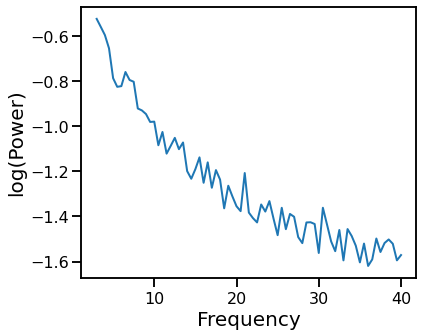

In [15]:
# Plot example simulated power spectrum from the group
plot_psds(freqs, psds[:, 10])

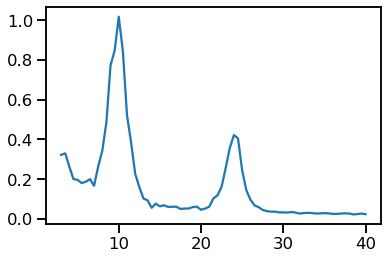

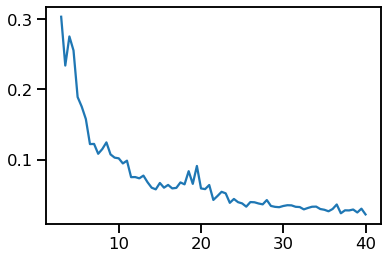

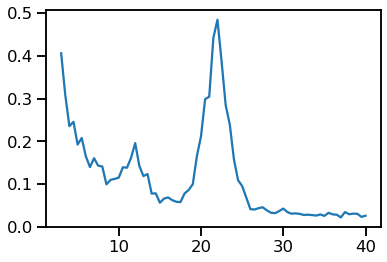

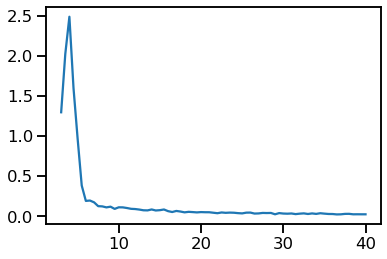

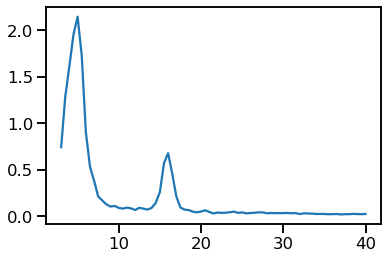

In [16]:
# Check out some of the simulated power spectra
for ind, psd in enumerate(psds.T):
    if ind < 5:
        plt.figure()
        plt.plot(freqs, psd)

In [17]:
# Initialize and set up for simulated data testing
sims = SimFits()
sims.get_fit_funcs()

In [18]:
# Check the fitting functions being used
print(list(sims.fit_funcs.keys()))

['OLS', 'OLS-EA', 'OLS-EO', 'RLM', 'RLM-EA', 'RLM-EO', 'RAN', 'RAN-EA', 'RAN-EO', 'EXP', 'EXP-EA', 'EXP-EO', 'FOOOF']


In [19]:
# Fit spectra: this fits all methods
sims.fit_spectra(exp_val, freqs, psds)

In [20]:
# Calculate metrics
avgs = sims.calc_avg_errs()
perc_good = sims.calc_perc_good()

In [21]:
# Check errors per fitting method
print('AVERAGE FIT ERRORS')
print_res(avgs)

AVERAGE FIT ERRORS
   RLM-EO   		 0.02400
   FOOOF    		 0.02434
   OLS-EO   		 0.02436
   EXP-EO   		 0.02436
   RAN      		 0.02479
   RAN-EO   		 0.02653
   RLM-EA   		 0.02745
   RAN-EA   		 0.03151
   EXP-EA   		 0.03192
   OLS-EA   		 0.03192
   RLM      		 0.04366
   OLS      		 0.07107
   EXP      		 0.07107


In [22]:
# Check errors per fitting method
print('PERCENTAGE FITS BELOW ERROR THRESHOLD')
print_res(perc_good)

PERCENTAGE FITS BELOW ERROR THRESHOLD
   RLM-EO   		 0.52000
   OLS-EO   		 0.52000
   EXP-EO   		 0.52000
   FOOOF    		 0.50667
   RAN      		 0.50000
   RAN-EO   		 0.47333
   RLM-EA   		 0.45333
   OLS-EA   		 0.44000
   EXP-EA   		 0.44000
   RAN-EA   		 0.42000
   RLM      		 0.39333
   OLS      		 0.36000
   EXP      		 0.36000


In [23]:
# Create a dataframe of the simulation errors
df = pd.DataFrame(sims.errs)

In [24]:
# Check the correlation structure between fit errors
df.corr()

,OLS,OLS-EA,OLS-EO,RLM,RLM-EA,RLM-EO,RAN,RAN-EA,RAN-EO,EXP,EXP-EA,EXP-EO,FOOOF
OLS,1.000000,0.861260,0.613652,0.933455,0.805691,0.600042,0.564828,0.388589,0.195526,1.000000,0.861260,0.613652,0.723281
OLS-EA,0.861260,1.000000,0.770591,0.846098,0.971755,0.741762,0.404629,0.488880,0.234538,0.861260,1.000000,0.770591,0.884075
OLS-EO,0.613652,0.770591,1.000000,0.572309,0.775578,0.971931,0.147095,0.518987,0.444807,0.613652,0.770591,1.000000,0.937284
RLM,0.933455,0.846098,0.572309,1.000000,0.837401,0.600245,0.642508,0.467574,0.223717,0.933455,0.846098,0.572310,0.703260
RLM-EA,0.805691,0.971755,0.775578,0.837401,1.000000,0.759118,0.382282,0.570249,0.229330,0.805691,0.971755,0.775578,0.894710
RLM-EO,0.600042,0.741762,0.971931,0.600245,0.759118,1.000000,0.152246,0.542768,0.475296,0.600042,0.741762,0.971931,0.900302
RAN,0.564828,0.404629,0.147095,0.642508,0.382282,0.152246,1.000000,0.176489,0.067621,0.564828,0.404629,0.147095,0.239315
RAN-EA,0.388589,0.488880,0.518987,0.467574,0.570249,0.542768,0.176489,1.000000,0.060454,0.388589,0.488880,0.518987,0.565345
RAN-EO,0.195526,0.234538,0.444807,0.223717,0.229330,0.475296,0.067621,0.060454,1.000000,0.195526,0.234538,0.444806,0.241143
EXP,1.000000,0.861260,0.613652,0.933455,0.805691,0.600042,0.564828,0.388589,0.195526,1.000000,0.861260,0.613652,0.723281


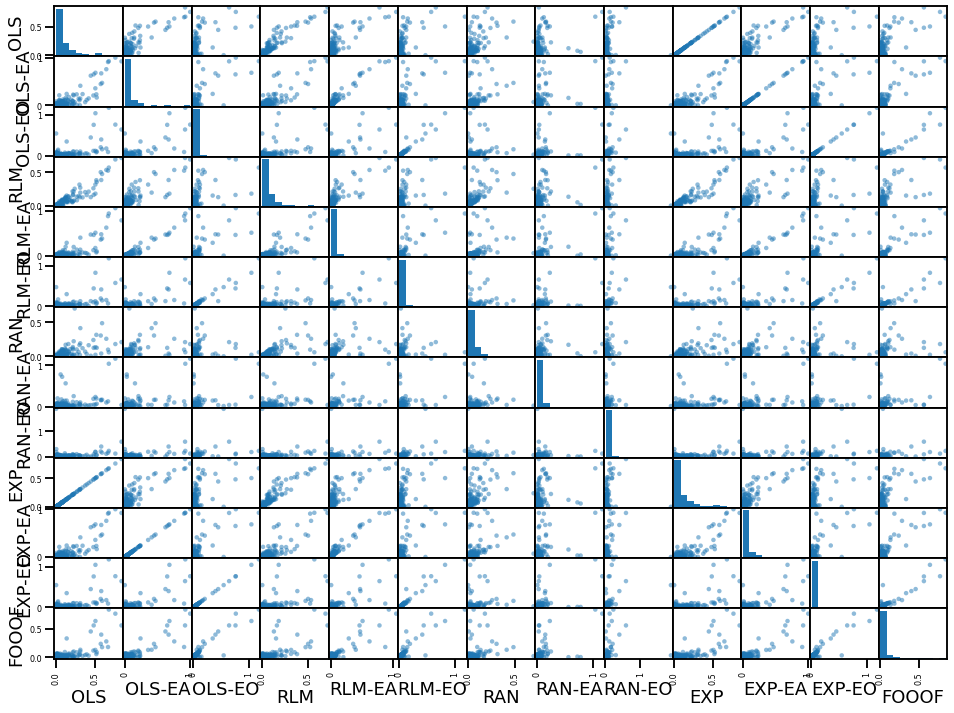

In [25]:
# Plot data distributions and inter-relations
pd.plotting.scatter_matrix(df, figsize=[16, 12]);

In [26]:
# Apply a normal test across fit-error distributions
normalities = df.apply(normaltest)

# Check which results of normal test
nt_df = pd.DataFrame([data[1] for data in normalities.values], index=normalities.index)
nt_df.style.applymap(color_red_or_green)

,0
OLS,0.000000
OLS-EA,0.000000
OLS-EO,0.000000
RLM,0.000000
RLM-EA,0.000000
RLM-EO,0.000000
RAN,0.000000
RAN-EA,0.000000
RAN-EO,0.000000
EXP,0.000000


In [27]:
# Save out simulated fit data to pickle
if SAVE_DATA:
    save_pickle(sims.errs, 'SimFits_test.p', db.sims_path)

In [28]:
# Check available simulated fit results files
sim_files = db.check_files('sims')
f_ind = sim_files.index('SimFits_test.p')

In [29]:
# # Load simulated fit results data from pickle file
# data = load_pickle(sim_files[f_ind], db.sims_path)
# sim_dat = SimFits()
# sim_dat.errs = data

In [ ]:
## RELOAD FILE

# # Check available simulated model fit files
# sim_files = db.check_files('sims')
# sim_files

# # Collect all fits together
# all_fits = SimFits()
# all_fits.get_fit_funcs()
# all_fits.get_err_dict(0)

# for f_name in sim_files:

#     data = load_pickle(f_name, db.sims_path)

#     temp = SimFits()
#     temp.errs = data
    
#     all_fits = all_fits + temp

## Compare Spectral Fitting

In [32]:
# Check how many PSDs are included in simulated data model fits
print(len(sims.errs['RAN-EA']))

150


In [33]:
# Check the average errors per method
print_res(sims.calc_avg_errs(avg='mean'))

   RAN-EO   		 0.05795
   RAN      		 0.05947
   FOOOF    		 0.06351
   RLM-EO   		 0.06389
   RAN-EA   		 0.07230
   EXP-EO   		 0.07272
   OLS-EO   		 0.07272
   RLM-EA   		 0.08356
   RLM      		 0.09246
   EXP-EA   		 0.10615
   OLS-EA   		 0.10615
   EXP      		 0.13615
   OLS      		 0.13615


In [34]:
# Check the standard deviation of errors per method
print_res(sims.calc_std_errs())

   RAN      		 0.09208
   FOOOF    		 0.13112
   RLM      		 0.13453
   RLM-EO   		 0.14593
   RAN-EA   		 0.15718
   RAN-EO   		 0.16470
   EXP-EO   		 0.17060
   OLS-EO   		 0.17060
   RLM-EA   		 0.17487
   EXP      		 0.17883
   OLS      		 0.17883
   EXP-EA   		 0.19543
   OLS-EA   		 0.19543


In [35]:
# Check the number of fits that pass a threshold, per method
print_res(sims.calc_perc_good(thresh=0.025))

   RLM-EO   		 0.52000
   OLS-EO   		 0.52000
   EXP-EO   		 0.52000
   FOOOF    		 0.50667
   RAN      		 0.50000
   RAN-EO   		 0.47333
   RLM-EA   		 0.45333
   OLS-EA   		 0.44000
   EXP-EA   		 0.44000
   RAN-EA   		 0.42000
   RLM      		 0.39333
   OLS      		 0.36000
   EXP      		 0.36000


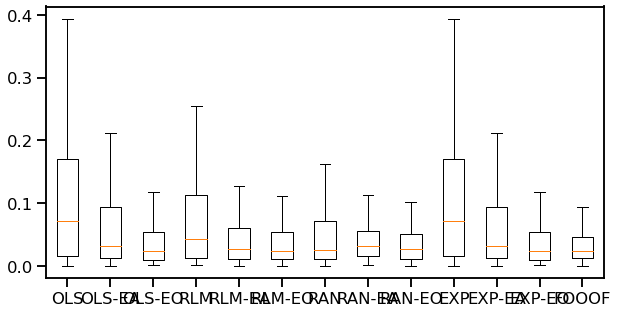

In [36]:
# Create boxplot of errors
boxplot_errors(sims.errs)

In [37]:
mains = ['OLS', 'RLM', 'RAN', 'EXP', 'FOOOF']
alphas = ['OLS-EA', 'RLM-EA', 'RAN-EA', 'EXP-EA', 'FOOOF']
oscs = ['OLS-EO', 'RLM-EO', 'RAN-EO', 'EXP-EO', 'FOOOF']

In [38]:
main_dicts = {label : sims.errs[label] for label in mains}
alphas_dicts = {label : sims.errs[label] for label in alphas}
oscs_dicts = {label : sims.errs[label] for label in oscs}

## Violin Plots

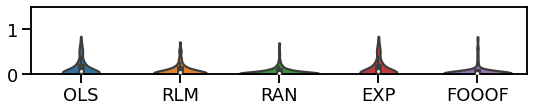

In [39]:
violin_errors(main_dicts, ylim=[0, 1.5])

if SAVE_FIG:
    plt.savefig(db.make_fig_name('SpectralFitting-Main', file_type='pdf')) 

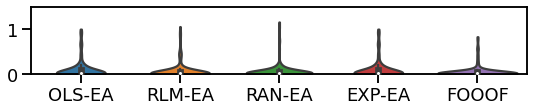

In [40]:
violin_errors(alphas_dicts, ylim=[0, 1.5])

if SAVE_FIG:
    plt.savefig(db.make_fig_name('SpectralFitting-EA', file_type='pdf'))

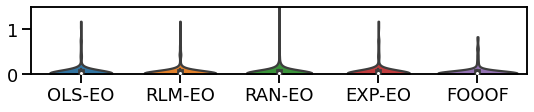

In [41]:
violin_errors(oscs_dicts, ylim = [0, 1.5])

if SAVE_FIG:
    plt.savefig(db.make_fig_name('SpectralFitting-EO', file_type='pdf'))

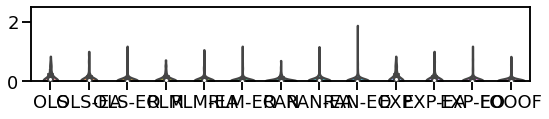

In [43]:
# Violin plot of error distributions
ax = violin_errors(sims.errs, ylim=[0, 2.5])

#if SAVE_FIG:
#    plt.savefig(db.make_fig_name('violin_plot', file_type='pdf'))

## Statistically Compare Methods

In [44]:
# Run comparisons between methods
comps = sims.comp_errs()

In [45]:
# Print out color-coded dataframe of comparison results
df = pd.DataFrame(comps, index=sims.errs.keys(), columns=sims.errs.keys())
df.style.applymap(color_red_or_green)

,OLS,OLS-EA,OLS-EO,RLM,RLM-EA,RLM-EO,RAN,RAN-EA,RAN-EO,EXP,EXP-EA,EXP-EO,FOOOF
OLS,1.000000,0.021439,0.000016,0.047476,0.000097,0.000007,0.000094,0.001368,0.000006,0.990442,0.021439,0.000016,0.000021
OLS-EA,0.021439,1.000000,0.043594,0.537692,0.127144,0.030129,0.141323,0.703920,0.051804,0.021439,0.989380,0.043594,0.067606
OLS-EO,0.000016,0.043594,1.000000,0.005037,0.582490,0.916778,0.532435,0.050692,0.887792,0.000016,0.043594,0.996814,0.815804
RLM,0.047476,0.537692,0.005037,1.000000,0.020478,0.003167,0.035219,0.194343,0.004123,0.047476,0.537692,0.005037,0.007793
RLM-EA,0.000097,0.127144,0.582490,0.020478,1.000000,0.496377,0.902533,0.180971,0.685728,0.000097,0.127144,0.582490,0.819941
RLM-EO,0.000007,0.030129,0.916778,0.003167,0.496377,1.000000,0.463287,0.032212,0.745338,0.000007,0.030129,0.917307,0.687686
RAN,0.000094,0.141323,0.532435,0.035219,0.902533,0.463287,1.000000,0.218715,0.599959,0.000095,0.141323,0.532435,0.716310
RAN-EA,0.001368,0.703920,0.050692,0.194343,0.180971,0.032212,0.218715,1.000000,0.075125,0.001368,0.705403,0.050692,0.096667
RAN-EO,0.000006,0.051804,0.887792,0.004123,0.685728,0.745338,0.599959,0.075125,1.000000,0.000006,0.051804,0.885690,0.983008
EXP,0.990442,0.021439,0.000016,0.047476,0.000097,0.000007,0.000095,0.001368,0.000006,1.000000,0.021439,0.000016,0.000021
